## Introduction

Working with these files can be a challenge, especially given their heterogeneous nature. Some preprocessing is required before they are ready for consumption by your CNN.

Fortunately, I participated in the LUNA16 competition as part of a university course on computer aided diagnosis, so I have some experience working with these files. At this moment we top the leaderboard there :)

**This tutorial aims to provide a comprehensive overview of useful steps to take before the data hits your ConvNet/other ML method.**

What we will cover:  

* **Loading the DICOM files**, and adding missing metadata  
* **Converting the pixel values to *Hounsfield Units (HU)***, and what tissue these unit values correspond to
* **Resampling** to an isomorphic resolution to remove variance in scanner resolution.
* **3D plotting**, visualization is very useful to see what we are doing.
* **Lung segmentation**
* **Normalization** that makes sense.
* **Zero centering** the scans.


---

Before we start, let's import some packages and determine the available patients.

In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import glob
import scipy.ndimage
import matplotlib.pyplot as plt
import ipyvolume

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '/media/mike/tera/data/databowl/kgsamples/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [2]:
def padcrop_vol(vol, newshape=[360, 360, 360]):
    vol2 = np.array(vol)
    shape = vol.shape
    z, y, x = shape
    mids = [d // 2 for d in shape]
    for dim in range(3):
        if shape[dim] < newshape[dim]:
            pad_amt = (newshape[dim] - shape[dim]) // 2
            parity = (shape[dim] & 1) ^ (newshape[dim] & 1)
            pad_tup = (pad_amt, pad_amt + parity) # 
            pad_list = [(0,0), (0,0), (0,0)]
            pad_list[dim] = pad_tup
            vol2 = np.pad(vol2, pad_list, mode='constant', constant_values=0)
        if shape[dim] > newshape[dim]:
            slc_amt = (shape[dim] - newshape[dim]) // 2
            parity = (shape[dim] & 1) ^ (newshape[dim] & 1)
            slc_tup = (slc_amt, shape[dim] - slc_amt - parity) # 
            null1, vol2, null2 = np.split(vol2, slc_tup, dim)

    return vol2

# Loading the files
Dicom is the de-facto file standard in medical imaging. This is my first time working with it, but it seems to be fairly straight-forward.  These files contain a lot of metadata (such as the pixel size, so how long one pixel is in every dimension in the real world). 

This pixel size/coarseness of the scan differs from scan to scan (e.g. the distance between slices may differ), which can hurt performance of CNN approaches. We can deal with this by isomorphic resampling, which we will do later.

Below is code to load a scan, which consists of multiple slices, which we simply save in a Python list. Every folder in the dataset is one scan (so one patient). One metadata field is missing, the pixel size in the Z direction, which is the slice thickness. Fortunately we can infer this, and we add this to the metadata.

In [3]:
labels = pd.read_csv('/media/mike/tera/data/databowl/stage1_labels.csv')

In [4]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

The unit of measurement in CT scans is the **Hounsfield Unit (HU)**, which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.  From Wikipedia:

![HU examples][1]

By default however, the returned values are not in this unit. Let's fix this.

Some scanners have cylindrical scanning bounds, but the output image is square. The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently corresponds to air. Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

  [1]: http://i.imgur.com/4rlyReh.png

In [5]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Let's take a look at one of the patients.

In [6]:
cancer_set = labels[labels['cancer'] == 1]
cancer_set

,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1
8,00edff4f51a893d80dae2d42a7f45ad1,1
15,0257df465d9e4150adef13303433ff1e,1
18,02801e3bbcc6966cb115a962012c35df,1
19,028996723faa7840bb57f57e28275e4c,1
27,04a8c47583142181728056310759dea1,1
31,05609fdb8fa0895ac8a9be373144dac7,1
32,059d8c14b2256a2ba4e38ac511700203,1


In [7]:
files = glob.glob(INPUT_FOLDER + '/*')
files = [os.path.basename(f) for f in files]
files

['0a099f2549429d29b32f349e95fb2244',
 '0c37613214faddf8701ca41e6d43f56e',
 '0c60f4b87afcb3e2dfa65abbbf3ef2f9',
 '0c0de3749d4fe175b7a5098b060982a1',
 '0a0c32c9e08cc2ea76a71649de56be6d',
 '0ca943d821204ceb089510f836a367fd',
 '0b20184e0cd497028bdd155d9fb42dc9',
 '0c9d8314f9c69840e25febabb1229fa4',
 '0a38e7597ca26f9374f8ea2770ba870d',
 '0c59313f52304e25d5a7dcf9877633b1',
 '0ddeb08e9c97227853422bd71a2a695e',
 '0bd0e3056cbf23a1cb7f0f0b18446068',
 '0d06d764d3c07572074d468b4cff954f',
 '0c98fcb55e3f36d0c2b6507f62f4c5f1',
 '0d941a3ad6c889ac451caf89c46cb92a',
 '00cba091fa4ad62cc3200a657aeb957e',
 '0d19f1c627df49eb223771c28548350e',
 '0d2fcf787026fece4e57be167d079383',
 '0acbebb8d463b4b9ca88cf38431aac69',
 '0de72529c30fe642bc60dcb75c87f6bd']

In [8]:
mask = pd.Series([True if f in files else False for f in labels['id'].values], index=labels.index)
len(mask)

1397

In [9]:
labels[mask]

,id,cancer
7,00cba091fa4ad62cc3200a657aeb957e,0
56,0a099f2549429d29b32f349e95fb2244,0
57,0a0c32c9e08cc2ea76a71649de56be6d,0
58,0a38e7597ca26f9374f8ea2770ba870d,0
59,0acbebb8d463b4b9ca88cf38431aac69,1
60,0bd0e3056cbf23a1cb7f0f0b18446068,0
61,0c0de3749d4fe175b7a5098b060982a1,1
62,0c37613214faddf8701ca41e6d43f56e,1
63,0c59313f52304e25d5a7dcf9877633b1,0
64,0c60f4b87afcb3e2dfa65abbbf3ef2f9,1


In [10]:
cancers = labels[mask][labels[mask]['cancer'] == 1] # gross. but effective
cancers

,id,cancer
59,0acbebb8d463b4b9ca88cf38431aac69,1
61,0c0de3749d4fe175b7a5098b060982a1,1
62,0c37613214faddf8701ca41e6d43f56e,1
64,0c60f4b87afcb3e2dfa65abbbf3ef2f9,1
68,0d06d764d3c07572074d468b4cff954f,1


In [11]:
patients = cancers['id'].values

In [12]:
patient_id = patients[1]
path = INPUT_FOLDER + patient_id
# slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]

0c37613214faddf8701ca41e6d43f56e


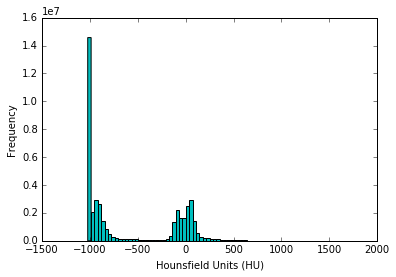

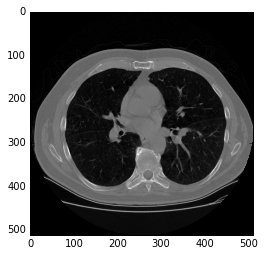

In [13]:
patient_id = patients[2]
print(patient_id)
first_patient = load_scan(INPUT_FOLDER + patient_id)
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

Looking at the table from Wikipedia and this histogram, we can clearly see which pixels are air and which are tissue. We will use this for lung segmentation in a bit :)


----------

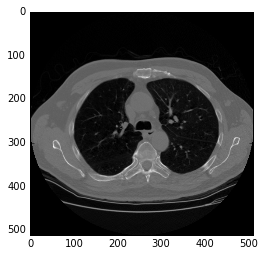

In [14]:
plt.imshow(first_patient_pixels[108], cmap=plt.cm.gray)


# Resampling
A scan may have a pixel spacing of `[2.5, 0.5, 0.5]`, which means that the distance between slices is `2.5` millimeters. For a different scan this may be `[1.5, 0.725, 0.725]`, this can be problematic for automatic analysis (e.g. using ConvNets)! 

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm*1mm*1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance. 

Whilst this may seem like a very simple step, it has quite some edge cases due to rounding. Also, it takes quite a while.

Below code worked well for us (and deals with the edge cases):

In [23]:
def resample(image, scan, new_spacing=[1,1,1], verbose=False):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))
#     spacing = np.array(float(scan[0].SliceThickness) 
#                        + float(scan[0].PixelSpacing[0]) + float(scan[0].PixelSpacing[1]))

    if verbose: print('Initial Spacing:', spacing)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    if verbose: print('RRF: {} RF: {}'.format(real_resize_factor, resize_factor))
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

Please note that when you apply this, to save the new spacing! Due to rounding this may be slightly off from the desired spacing (above script picks the best possible spacing with rounding).

Let's resample our patient's pixels to an isomorphic resolution of 1 by 1 by 1 mm.

In [16]:
type(first_patient)
len(first_patient)

164

In [17]:
first_patient[0].SliceThickness

'2.0'

In [18]:
first_patient[0].PixelSpacing

['0.703125', '0.703125']

In [24]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1], True)
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Initial Spacing: [ 2.        0.703125  0.703125]
RRF: [ 2.        0.703125  0.703125] RF: [ 2.        0.703125  0.703125]
Shape before resampling	 (164, 512, 512)
Shape after resampling	 (328, 360, 360)


In [20]:
spacing

array([ 1.,  1.,  1.])

In [21]:
# np.save('resamp1', pix_resampled)

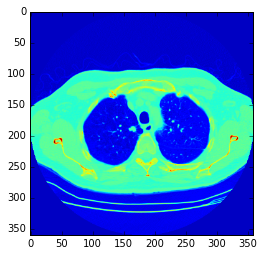

In [22]:
plt.imshow(pix_resampled[250])

In [ ]:
plt.imshow(pix_resampled[120][::2,::2])

In [ ]:
plt.imshow(pix_resampled[120][::3,::3])

In [ ]:
px3 = pix_resampled[::3,::3,]

In [ ]:
img = pix_resampled[120]
image = scipy.ndimage.interpolation.zoom(img, [1/4,1/4])
print(image.shape)
plt.imshow(image)

In [ ]:
ratio = 1/2
image = scipy.ndimage.interpolation.zoom(pix_resampled, [ratio,ratio,ratio])
print(image.shape)


In [ ]:
plt.imshow(image[60])

In [ ]:
# [plt.imsave('im/sl{:03d}.png'.format(i), slc) for i, slc in enumerate(image)]

In [ ]:
pix_resampled = image

# 3D plotting the scan
For visualization it is useful to be able to show a 3D image of the scan. Unfortunately, the packages available in this Kaggle docker image is very limited in this sense, so we will use marching cubes to create an approximate mesh for our 3D object, and plot this with matplotlib. Quite slow and ugly, but the best we can do.

In [ ]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

Our plot function takes a threshold argument which we can use to plot certain structures, such as all tissue or only the bones. 400 is a good threshold for showing the bones only (see Hounsfield unit table above). Let's do this!

In [ ]:
plot_3d(pix_resampled, 400)

In [ ]:
patient_id

In [ ]:
np.amax(pix_resampled), np.amin(pix_resampled)

In [ ]:
pix_resampled -= np.amin(pix_resampled)

In [ ]:
pix_resampled = pix_resampled[:,::-1,::] # flip to match aeskulap

In [ ]:
np.amax(pix_resampled), np.amin(pix_resampled)

In [ ]:
mask = np.ones(pix_resampled.shape)
mz, my, mx = pix_resampled.shape
print(mz, my, mx)
mask[140:] = 0
mask[:110] = 0
mask[:,:50] = 0
mask[:,my-50:] = 0
mask[:,:,mx-50:] = 0
mask[:,:,:50] = 0
mask2 = np.less(pix_resampled,1267)
mask3 = np.greater(pix_resampled,400)

ipyvolume.quickvolshow(pix_resampled*mask*mask3, width=1000, height=1000, level=[.26, .3, .85], level_width=[.5, .1, .05])

In [ ]:
print(pix_resampled.shape)
pix2 = padcrop_vol(pix_resampled, [100, 100, 100])
ipyvolume.quickvolshow(pix2, width=1000, height=1000, level=[.26, .3, .26], level_width=[.5, .1, .05])

Spooky!

# Lung segmentation
In order to reduce the problem space, we can segment the lungs (and usually some tissue around it). The method that me and my student colleagues developed was quite effective. 

It involves quite a few smart steps. It consists of a series of applications of region growing and morphological operations. In this case, we will use only connected component analysis.

The steps:  

* Threshold the image (-320 HU is a good threshold, but it doesn't matter much for this approach)
* Do connected components, determine label of air around person, fill this with 1s in the binary image
* Optionally: For every axial slice in the scan, determine the largest solid connected component (the body+air around the person), and set others to 0. This fills the structures in the lungs in the mask.
* Keep only the largest air pocket (the human body has other pockets of air here and there).

In [ ]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [ ]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

In [ ]:
plot_3d(segmented_lungs, 0)

Beautiful! 

But there's one thing we can fix, it is probably a good idea to include structures within the lung (as the nodules are solid), we do not only want to air in the lungs. 

In [ ]:
plot_3d(segmented_lungs_fill, 0)

That's better. Let's also visualize the difference between the two.

In [ ]:
lungdiff = segmented_lungs_fill - segmented_lungs
plot_3d(lungdiff, 0)

In [ ]:
patient_id

In [ ]:
plt.figure(figsize=(10,10))
ipyvolume.quickvolshow(segmented_lungs_fill, width=800, height=800, s=10)

Pretty cool, no? 

Anyway, when you want to use this mask, **remember to first apply a dilation morphological operation** on it (i.e. with a circular kernel).  This expands the mask in all directions. The air + structures in the lung alone will not contain all nodules, in particular it will miss those that are stuck to the side of the lung, where they often appear! So expand the mask a little :)

**This segmentation may fail for some edge cases**. It relies on the fact that the air outside the patient is not connected to the air in the lungs. If the patient has a [tracheostomy](https://en.wikipedia.org/wiki/Tracheotomy), this will not be the case, I do not know whether this is present in the dataset. Also, particulary noisy images (for instance due to a pacemaker in the image below) this method may also fail. Instead, the second largest air pocket in the body will be segmented. You can recognize this by checking the fraction of image that the mask corresponds to, which will be very small for this case. You can then first apply a morphological closing operation with a kernel a few mm in size to close these holes, after which it should work (or more simply, do not use the mask for this image). 

![pacemaker example][1]

# Normalization
Our values currently range from -1024 to around 2000. Anything above 400 is not interesting to us, as these are simply bones with different radiodensity.  A commonly used set of thresholds in the LUNA16 competition to normalize between are -1000 and 400. Here's some code you can use:


  [1]: http://i.imgur.com/po0eX1L.png

In [ ]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

# Zero centering

As a final preprocessing step, it is advisory to zero center your data so that your mean value is 0. To do this you simply subtract the mean pixel value from all pixels. 

To determine this mean you simply average all images in the whole dataset.  If that sounds like a lot of work, we found this to be around 0.25 in the LUNA16 competition. 

**Warning: Do not zero center with the mean per image (like is done in some kernels on here). The CT scanners are calibrated to return accurate HU measurements. There is no such thing as an image with lower contrast or brightness like in normal pictures.**

In [ ]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

# What's next? 

With these steps your images are ready for consumption by your CNN or other ML method :). You can do all these steps offline (one time and save the result), and I would advise you to do so and let it run overnight as it may take a long time. 

**Tip:** To save storage space, don't do normalization and zero centering beforehand, but do this online (during training, just after loading). If you don't do this yet, your image are int16's, which are smaller than float32s and easier to compress as well.

**If this tutorial helped you at all, please upvote it and leave a comment :)**

In [29]:
ary = np.load('/media/mike/tera/data/databowl/resampled_images/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd.npy')
ary.shape
ary[ary ]

(302, 390, 390)

In [30]:
ipyvolume.quickvolshow(ary, width=1000, height=1000, level=[.26, .3, .26], level_width=[.5, .1, .05])

/home/mike/ve/ml/lib/python3.5/site-packages/ipyvolume/serialize.py:21: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [31]:
np.amin(ary), np.amax(ary)

(-3709, 2067)